# **Exploring GAN Variants for Balancing Imbalanced Datasets**


## 1. Dataset & Setup


### MAIN IMPORTS


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### IMPORTING THE DATASET


In [2]:
dataset = pd.read_csv("./creditcard.csv", sep=";")

In [3]:
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### NORMALIZE 'Amount' AND 'Time' COLUMNS


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dataset["Scaled_Amount"] = scaler.fit_transform(dataset["Amount"].values.reshape(-1, 1))
dataset["Scaled_Time"] = scaler.fit_transform(dataset["Time"].values.reshape(-1, 1))

dataset.drop(["Time", "Amount"], axis=1, inplace=True)

In [5]:
dataset.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount,Scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### VISUALIZING DATA IMBALANCE


Class
0    284315
1       492
Name: count, dtype: int64


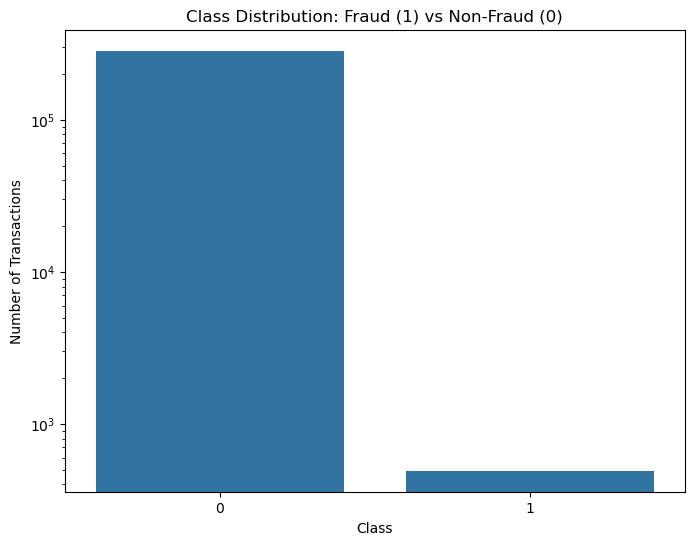

In [6]:
import seaborn as sns

counts = dataset["Class"].value_counts()
print(counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Class Distribution: Fraud (1) vs Non-Fraud (0)")
plt.xlabel("Class")
plt.ylabel("Number of Transactions")
plt.yscale("log")
plt.show()

In [7]:
import plotly.express as px

counts = dataset["Class"].value_counts().reset_index()
counts.columns = ["Class_Type", "Count"]

counts["Class_Type"] = counts["Class_Type"].map(
    {0: "Normal Transaction", 1: "Fraudulent Transaction"}
)

fig = px.pie(
    counts,
    values="Count",
    names="Class_Type",
    title="<b>Class Imbalance: Normal vs. Fraudulent Transactions</b>",
    color="Class_Type",
    color_discrete_map={
        "Normal Transaction": "#636EFA",
        "Fraudulent Transaction": "#EF553B",
    },
    hole=0.6,
)

fig.update_traces(textposition="outside", textinfo="percent+label", pull=[0, 0.2])

fig.show()

## 2. The GANs


### PYTORCH IMPORTS


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### PREPARE THE MINORITY DATA


In [9]:
fraud_df = dataset[dataset["Class"] == 1].drop("Class", axis=1)

fraud_data = torch.tensor(fraud_df.values, dtype=torch.float32)

loader = DataLoader(TensorDataset(fraud_data), batch_size=64, shuffle=True)

print(f"Training GAN on {len(fraud_df)} fraud samples...")

Training GAN on 492 fraud samples...


### **I.THE VANILLA GAN IMPLEMENTATION**


In [10]:
class Generator(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            # Layer 2
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            # Layer 3
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            # Output Layer
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):

    def __init__(self, input_dim):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # Layer 2
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # Layer 3
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            # Output Layer
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

#### VANILLA GAN TRAINING LOOP


In [11]:
# SETUP

z_dim = 100
data_dim = fraud_data.shape[1]

generator = (
    Generator(z_dim, data_dim).cuda()
    if torch.cuda.is_available()
    else Generator(z_dim, data_dim)
)
discriminator = (
    Discriminator(data_dim).cuda()
    if torch.cuda.is_available()
    else Discriminator(data_dim)
)

lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# TRAINING PHASE

from tqdm import tqdm

epochs = 500

for epoch in range(epochs):

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for (real_samples,) in loop:
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        ## Labels ##

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ## Train Discriminator ##

        optimizer_D.zero_grad()

        outputs = discriminator(real_samples)
        d_loss_real = criterion(outputs, real_labels)  # -> Real Data Loss

        noise = torch.randn(batch_size, z_dim).to(device)
        fake_samples = generator(noise)
        outputs = discriminator(fake_samples.detach())
        d_loss_fake = criterion(outputs, fake_labels)  # -> Fake Data Loss

        d_loss = d_loss_real + d_loss_fake  # -> Combined Loss

        d_loss.backward()
        optimizer_D.step()

        ## Train Generator ##

        optimizer_G.zero_grad()

        outputs = discriminator(fake_samples)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

        ## Visualization ##
        loop.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

print("Training Finished!")

Epoch 500/500: 100%|██████████| 8/8 [00:00<00:00, 46.18it/s, D_Loss=1.13, G_Loss=0.972]

Training Finished!


#### SAVE THE VANILLA GAN MODELS


In [13]:
import os

if not os.path.exists("models"):
    os.makedirs("models")

# Save the Generator
torch.save(generator.state_dict(), "models/fraud_generator_vanilla.pth")

# Save the Discriminator
torch.save(discriminator.state_dict(), "models/fraud_discriminator_vanilla.pth")

print("✅ Models saved successfully in the 'models/' folder.")
print("   - Generator: models/fraud_generator_vanilla.pth")
print("   - Discriminator: models/fraud_discriminator_vanilla.pth")

✅ Models saved successfully in the 'models/' folder.
   - Generator: models/fraud_generator_vanilla.pth
   - Discriminator: models/fraud_discriminator_vanilla.pth


### **II. ANOTHER GAN VARIANT IMPLEMENTATION: Wasserstein GAN (WGAN)**


#### Define the WGAN Models


In [14]:
class GeneratorWGAN(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(GeneratorWGAN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.model(x)


# Critic replaces Discriminator
class Critic(nn.Module):

    def __init__(self, input_dim):

        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            # CHANGE 1: Remove Sigmoid
            # Output is a raw score (can be negative or positive infinity)
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x)

#### WGAN Training Loop


In [15]:
# SETUP

lr = 0.00005
clip_value = 0.01  # The "Clipping" threshold to enforce Lipschitz constraint
n_critic = 5  # Train Critic 5 times for every 1 Generator step

generator_wgan = GeneratorWGAN(z_dim, data_dim).to(device)
critic = Critic(data_dim).to(device)

optimizer_G_wgan = optim.RMSprop(
    generator_wgan.parameters(), lr=lr
)  # RMSprop is traditionally used for WGAN, though Adam works too
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

In [16]:
# TRAINING PHASE

import torch.optim as optim
from tqdm import tqdm

epochs = 500

for epoch in range(epochs):
    loop = tqdm(loader, desc=f"WGAN Epoch {epoch+1}/{epochs}", leave=True)

    for batch_idx, (real_samples,) in enumerate(loop):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        ## Train Critic (The "Discriminator") multiple times ##
        for _ in range(n_critic):
            noise = torch.randn(batch_size, z_dim).to(device)
            fake_samples = generator_wgan(noise)

            critic_real = critic(real_samples)
            critic_fake = critic(fake_samples)

            # CHANGE 2: Wasserstein Loss
            # Maximize: E[critic(real)] - E[critic(fake)]
            # Which is same as Minimize: -(mean(critic(real)) - mean(critic(fake)))
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimizer_C.step()

            # CHANGE 3: Weight Clipping
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        ## 2. Train Generator ##

        # Generator wants to Maximize E[critic(fake)]
        # Which is Minimize -mean(critic(fake))

        fake_samples_new = generator_wgan(torch.randn(batch_size, z_dim).to(device))
        gen_fake = critic(fake_samples_new)

        loss_gen = -torch.mean(gen_fake)

        optimizer_G_wgan.zero_grad()
        loss_gen.backward()
        optimizer_G_wgan.step()

        loop.set_postfix(C_Loss=loss_critic.item(), G_Loss=loss_gen.item())

print("WGAN Training Finished!")

WGAN Epoch 500/500: 100%|██████████| 8/8 [00:00<00:00, 13.35it/s, C_Loss=-0.0213, G_Loss=0.0822]  

WGAN Training Finished!


#### SAVE WGAN MODELS


In [17]:
torch.save(generator_wgan.state_dict(), "models/fraud_generator_wgan.pth")
torch.save(critic.state_dict(), "models/fraud_critic_wgan.pth")

print("✅ WGAN Models saved successfully.")

✅ WGAN Models saved successfully.


## 3. Classification & Evaluation


### MAIN IMPORTS


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

### PREPARE THE DATA


In [19]:
X = dataset.drop("Class", axis=1)
y = dataset["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Original Training Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Original Training Shape: (227845, 30)
Test Shape: (56962, 30)


### CALCULATE HOW MANY SAMPLES WE NEED TO GENERATE TO REACH 50/50 BALANCE


In [20]:
num_normal = y_train.value_counts()[0]
num_fraud = y_train.value_counts()[1]
n_to_generate = num_normal - num_fraud

print(f"Normal samples in Train: {num_normal}")
print(f"Fraud samples in Train: {num_fraud}")
print(f"Need to generate: {n_to_generate} synthetic fraud samples.")

Normal samples in Train: 227451
Fraud samples in Train: 394
Need to generate: 227057 synthetic fraud samples.


### HELPER FUNCTION TO GENERATE DATA


In [21]:
def generate_synthetic_data(model, n_samples):

    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim).to(device)
        synthetic_data = model(z).cpu().numpy()
    synthetic_labels = np.ones(n_samples)

    return synthetic_data, synthetic_labels

- **THE MODEL THAT WILL BE USED IN THE 3 SCENARIOS IS A "RANDOM FOREST" MODEL**


### SCENARIO A: TRAIN ON ORIGINAL IMBALANCED DATA


In [22]:
rf_a = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [23]:
rf_a.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [24]:
y_pred_a = rf_a.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred_a))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [26]:
conf_matrix_a = confusion_matrix(y_test, y_pred_a)
conf_matrix_a

array([[56859,     5],
       [   18,    80]])

### SCENARIO B: TRAIN ON ORIGINAL + VANILLA GAN


In [27]:
z_dim = 100
data_dim = X_train.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
loaded_vanilla_generator = Generator(z_dim, data_dim).to(device)

loaded_vanilla_generator.load_state_dict(
    torch.load("models/fraud_generator_vanilla.pth")
)

loaded_vanilla_generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [29]:
X_gen_vanilla, y_gen_vanilla = generate_synthetic_data(
    loaded_vanilla_generator, n_to_generate
)

In [30]:
X_tran_vanilla = np.vstack([X_train.values, X_gen_vanilla])
y_train_vanilla = np.concatenate([y_train.values, y_gen_vanilla])

In [31]:
rf_b = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [32]:
rf_b.fit(X_tran_vanilla, y_train_vanilla)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [33]:
y_pred_b = rf_b.predict(X_test.values)

In [34]:
print(classification_report(y_test, y_pred_b))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.84      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [35]:
conf_matrix_b = confusion_matrix(y_test, y_pred_b)
conf_matrix_b

array([[56847,    17],
       [   16,    82]])

### SCENARIO C: TRAIN ON ORIGINAL + WGAN


In [36]:
loaded_wgan_generator = GeneratorWGAN(z_dim, data_dim).to(device)

loaded_wgan_generator.load_state_dict(torch.load("models/fraud_generator_wgan.pth"))

loaded_wgan_generator.eval()

GeneratorWGAN(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [37]:
X_gen_wgan, y_gen_wgan = generate_synthetic_data(loaded_wgan_generator, n_to_generate)

In [38]:
X_train_wgan = np.vstack([X_train.values, X_gen_wgan])
y_train_wgan = np.concatenate([y_train.values, y_gen_wgan])

In [39]:
rf_c = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [40]:
rf_c.fit(X_train_wgan, y_train_wgan)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [41]:
y_pred_c = rf_c.predict(X_test.values)

In [42]:
print(classification_report(y_test, y_pred_c))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.42      0.89      0.57        98

    accuracy                           1.00     56962
   macro avg       0.71      0.94      0.79     56962
weighted avg       1.00      1.00      1.00     56962



In [43]:
conf_matrix_c = confusion_matrix(y_test, y_pred_c)
conf_matrix_c

array([[56746,   118],
       [   11,    87]])

### SAVE THE 3 RANDOM FOREST MODELS


In [44]:
import joblib
import os

if not os.path.exists("models"):
    os.makedirs("models")

# Save the 3 Classifiers
joblib.dump(rf_a, "models/rf_scenario_a_baseline.pkl")
joblib.dump(rf_b, "models/rf_scenario_b_vanilla.pkl")
joblib.dump(rf_c, "models/rf_scenario_c_wgan.pkl")

print("✅ Classifiers saved successfully:")

✅ Classifiers saved successfully:


### SUMMARY TABLE


In [45]:
results = {
    "Model": ["Baseline", "Vanilla GAN", "WGAN"],
    "F1-Score (Fraud)": [
        f1_score(y_test, y_pred_a),
        f1_score(y_test, y_pred_b),
        f1_score(y_test, y_pred_c),
    ],
}
print("\n--- FINAL COMPARISON ---")
print(pd.DataFrame(results))


--- FINAL COMPARISON ---
         Model  F1-Score (Fraud)
0     Baseline          0.874317
1  Vanilla GAN          0.832487
2         WGAN          0.574257


### VISUALIZATION: CONFUSION MATRICES


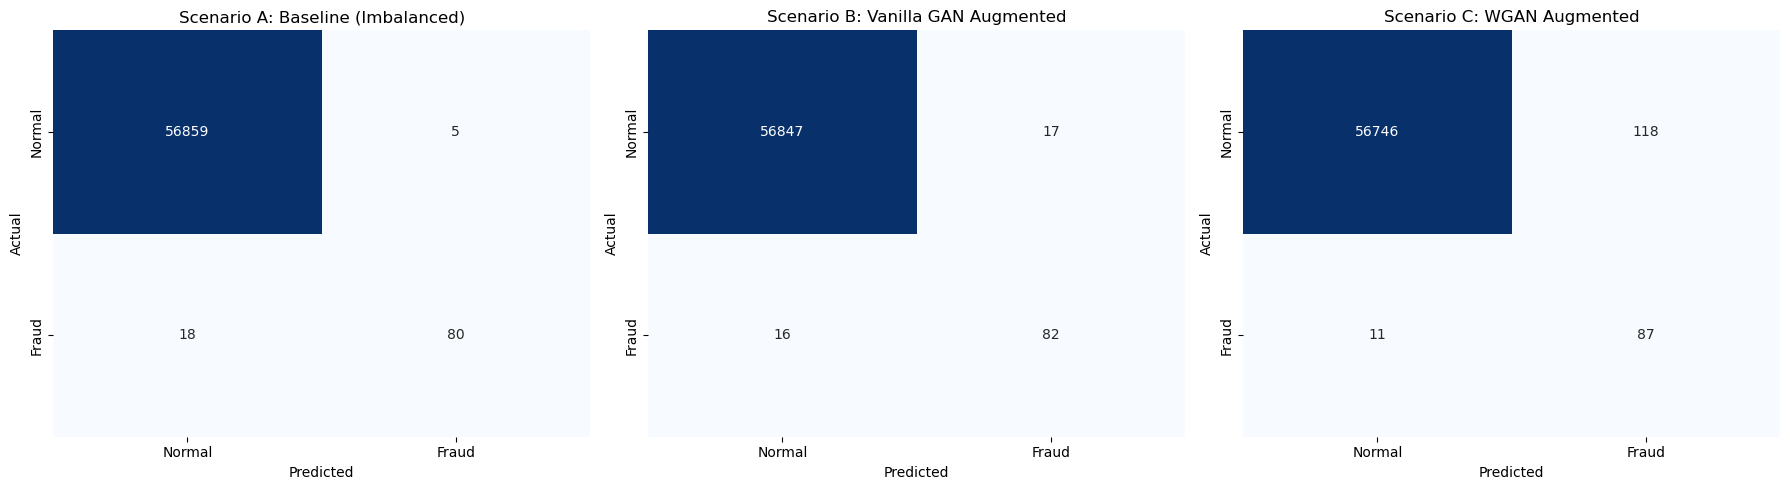

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scenarios = [
    ("Scenario A: Baseline (Imbalanced)", conf_matrix_a),
    ("Scenario B: Vanilla GAN Augmented", conf_matrix_b),
    ("Scenario C: WGAN Augmented", conf_matrix_c),
]

for ax, (title, cm) in zip(axes, scenarios):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(["Normal", "Fraud"])
    ax.set_yticklabels(["Normal", "Fraud"])

plt.tight_layout()
plt.show()

### VISUALIZATION: THE PRECISION-RECALL CURVE


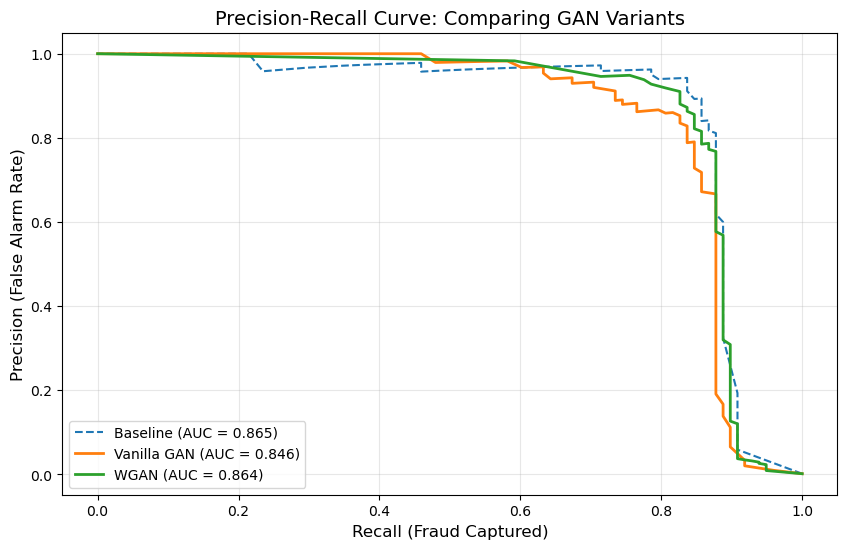

In [47]:
from sklearn.metrics import precision_recall_curve, auc

# Get Probabilities (Confidence scores) instead of hard 0/1 predictions
# We need the probability of Class 1 (Fraud)
y_probs_a = rf_a.predict_proba(X_test)[:, 1]
y_probs_b = rf_b.predict_proba(X_test.values)[:, 1]
y_probs_c = rf_c.predict_proba(X_test.values)[:, 1]

# Calculate Curves
prec_a, rec_a, _ = precision_recall_curve(y_test, y_probs_a)
prec_b, rec_b, _ = precision_recall_curve(y_test, y_probs_b)
prec_c, rec_c, _ = precision_recall_curve(y_test, y_probs_c)

# Calculate Area Under Curve (AUC-PR) - A single score for quality
auc_a = auc(rec_a, prec_a)
auc_b = auc(rec_b, prec_b)
auc_c = auc(rec_c, prec_c)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(rec_a, prec_a, label=f"Baseline (AUC = {auc_a:.3f})", linestyle="--")
plt.plot(rec_b, prec_b, label=f"Vanilla GAN (AUC = {auc_b:.3f})", linewidth=2)
plt.plot(rec_c, prec_c, label=f"WGAN (AUC = {auc_c:.3f})", linewidth=2)

plt.title("Precision-Recall Curve: Comparing GAN Variants", fontsize=14)
plt.xlabel("Recall (Fraud Captured)", fontsize=12)
plt.ylabel("Precision (False Alarm Rate)", fontsize=12)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

### VISUALIZATION: THE "TRADE-OFF" BAR CHART


Note how WGAN (Right) has the highest (Recall) but lowest (Precision).


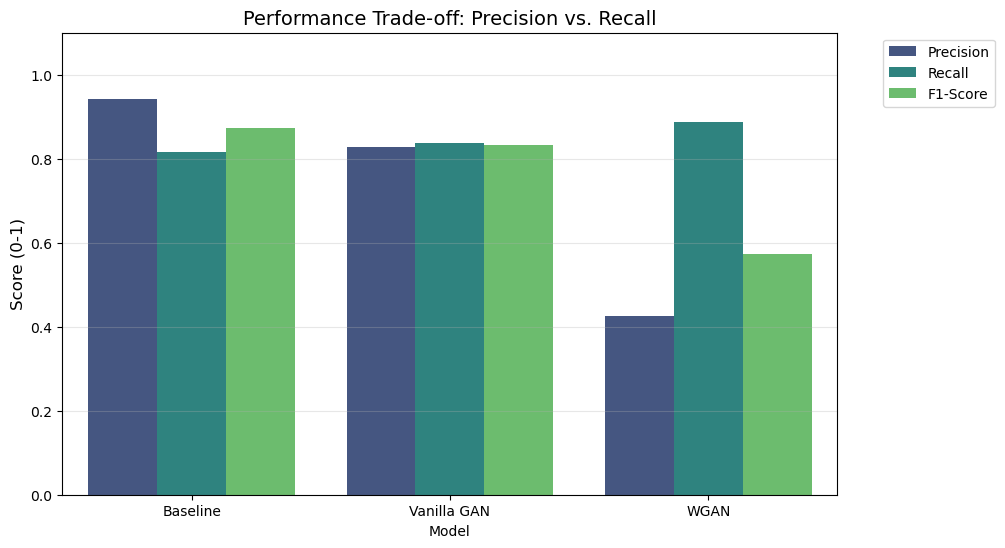

In [48]:
# --- Data Prep ---
from sklearn.metrics import precision_score, recall_score, f1_score

models = ["Baseline", "Vanilla GAN", "WGAN"]
preds = [y_pred_a, y_pred_b, y_pred_c]

# Calculate metrics for Class 1 (Fraud) only
metrics_data = {"Model": [], "Metric": [], "Score": []}

for name, pred in zip(models, preds):
    metrics_data["Model"].extend([name] * 3)
    metrics_data["Metric"].extend(["Precision", "Recall", "F1-Score"])
    metrics_data["Score"].extend(
        [
            precision_score(y_test, pred),
            recall_score(y_test, pred),
            f1_score(y_test, pred),
        ]
    )

df_metrics = pd.DataFrame(metrics_data)

# --- Plotting ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x="Model", y="Score", hue="Metric", palette="viridis")

plt.title("Performance Trade-off: Precision vs. Recall", fontsize=14)
plt.ylim(0, 1.1)
plt.ylabel("Score (0-1)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)

# Add text annotations
print("Note how WGAN (Right) has the highest (Recall) but lowest (Precision).")
plt.show()

### VISUALIZATOIN: THE "COST OF ERROR" ANALYSIS


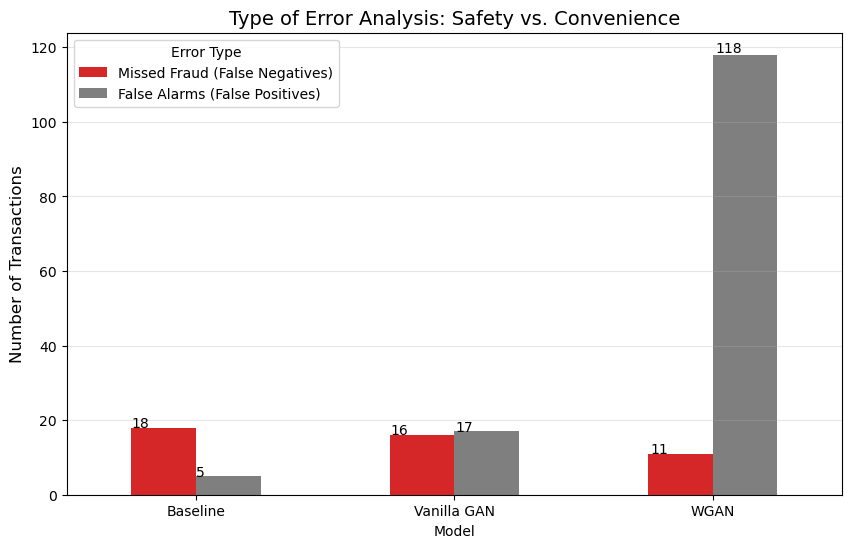

In [49]:
# Extract Errors from Confusion Matrices
# [0,1] is False Positive, [1,0] is False Negative
errors = {
    "Model": ["Baseline", "Vanilla GAN", "WGAN"],
    "Missed Fraud (False Negatives)": [
        conf_matrix_a[1, 0],
        conf_matrix_b[1, 0],
        conf_matrix_c[1, 0],
    ],
    "False Alarms (False Positives)": [
        conf_matrix_a[0, 1],
        conf_matrix_b[0, 1],
        conf_matrix_c[0, 1],
    ],
}

df_errors = pd.DataFrame(errors)
df_errors = df_errors.set_index("Model")

ax = df_errors.plot(
    kind="bar", stacked=False, figsize=(10, 6), color=["#d62728", "#7f7f7f"]
)

plt.title("Type of Error Analysis: Safety vs. Convenience", fontsize=14)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Error Type")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()